In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# SciPy

SciPy is a collection of numerical algorithms with python interfaces.  In many cases, these interfaces are wrappers around standard numerical libraries that have been developed in the community and are used with other languages.  Usually detailed references are available to explain the implementation.

There are many subpackages generally, you load the subpackages separately, e.g.

```
from scipy import linalg, optimize
```
then you have access to the methods in those namespaces


# Numerical Methods 

One thing to keep in mind -- all numerical methods have strengths and weaknesses, and make assumptions.  You should always do some research into the method to understand what it is doing.

It is also always a good idea to run a new method on some test where you know the answer, to make sure it is behaving as expected.

# Integration

we'll do some integrals of the form

$$I = \int_a^b f(x) dx$$

We can imagine two situations:
* our function $f(x)$ is given by an analytic expression.  This gives us the freedom to pick our integration points, and in general can allow us to optimize our result and get high accuracy
* our function $f(x)$ is defined on at a set of (possibly regular spaced) points.  

In numerical analysis, the term _quadrature_ is used to describe any integration method that represents the integral as the weighted sum of a discrete number of points.

In [3]:
from scipy import integrate
#help(integrate)

quad is the basic integrator for a general (not sampled) function.  It uses a general-interface from the Fortran package QUADPACK (QAGS or QAGI).  It will return the integral in an interval and an estimate of the error in the approximation

In [4]:
def f(x):
    return np.sin(x)**2

In [5]:
I, err = integrate.quad(f, 0.0, 2.0*np.pi, epsabs=1.e-14)
print(I)
print(err)

3.141592653589793
2.3058791671639882e-09


In [6]:
help(integrate.quad)

Help on function quad in module scipy.integrate.quadpack:

quad(func, a, b, args=(), full_output=0, epsabs=1.49e-08, epsrel=1.49e-08, limit=50, points=None, weight=None, wvar=None, wopts=None, maxp1=50, limlst=50)
    Compute a definite integral.
    
    Integrate func from `a` to `b` (possibly infinite interval) using a
    technique from the Fortran library QUADPACK.
    
    Parameters
    ----------
    func : {function, scipy.LowLevelCallable}
        A Python function or method to integrate.  If `func` takes many
        arguments, it is integrated along the axis corresponding to the
        first argument.
    
        If the user desires improved integration performance, then `f` may
        be a `scipy.LowLevelCallable` with one of the signatures::
    
            double func(double x)
            double func(double x, void *user_data)
            double func(int n, double *xx)
            double func(int n, double *xx, void *user_data)
    
        The ``user_data`` is the 

sometimes our integrand function takes optional arguments

In [7]:
def g(x, A, sigma):
    return A*np.exp(-x**2/sigma**2)

In [8]:
I, err = integrate.quad(g, -1.0, 1.0, args=(1.0, 2.0))
print(I, err)

1.8451240256511698 2.0484991765669867e-14


numpy defines the inf quantity which can be used in the integration limits.  We can integrate a Gaussian (we know the answer is sqrt(pi)

Note: behind the scenes, what the integration function does is do a variable transform like: $t = 1/x$.  This works when one limit is $\infty$, giving

$$\int_a^b f(x) dx = \int_{1/b}^{1/a} \frac{1}{t^2} f\left (\frac{1}{t}\right) dt$$

In [9]:
I, err = integrate.quad(g, -np.inf, np.inf, args=(1.0, 1.0))
print(I, err)
x=np.sqrt(np.pi)
print(x)

1.7724538509055159 1.4202636780944923e-08
1.7724538509055159


### Multidimensional integrals

multidimensional integration can be done with successive calls to quad(), but there are wrappers that help

Let's compute 

$$I = \int_{y=0}^{1/2} \int_{x=0}^{1-2y} xy dxdy = \frac{1}{96}$$

(this example comes from the SciPy tutorial)

Notice that the limits of integration in x depend on y.

Note the form of the function:

```
dblquad(f, a, b, ylo, yhi)
```
where `f` = `f(y, x)` -- the y argument is first

The integral will be from: $x = [a,b]$, and $y$ = `ylo(x)`, $y$ = `yhi(x)`

In [10]:
def integrand(x,y):
    return x*y

def x_lower_lim(y):
    return 0
    
def x_upper_lim(y):
    return 1-2*y

# we change the definitions of x and y in this call
I, err = integrate.dblquad(integrand, 0.0, 0.5, x_lower_lim, x_upper_lim)
print(I, 1.0/I)


0.010416666666666668 95.99999999999999


If you remember the python lambda functions (one expression functions), you can do this more compactly:

In [11]:
I, err = integrate.dblquad(lambda x, y: x*y, 0.0, 0.5, lambda y: 0, lambda y: 1-2*y)
print(I)

0.010416666666666668


### integration of a sampled function

here we integrate a function that is defined only at a sequece of points.  Recall that Simpson's rule will use piecewise parabola data.  Let's compute

$$I = \int_0^{2\pi} f(x_i) dx$$

with $x_i = 0, \ldots, 2\pi$ defined at $N$ points

In [12]:
N = 17
x = np.linspace(0.0, 2.0*np.pi, N, endpoint=True)
y = np.sin(x)**2

I = integrate.simps(y, x)
print(I)

3.141592653589793


Romberg integration is specific to equally-spaced samples, where $N = 2^k + 1$  and can be more converge faster (it uses extrapolation of coarser integration results to achieve higher accuracy)

In [13]:
N = 17
x = np.linspace(0.0, 2.0*np.pi, N, endpoint=True)
y = np.sin(x)**2

I = integrate.romb(y, dx=x[1]-x[0])
print(I)

3.1430658353300385


# Interpolation

Interpolation fills in the gaps between a discrete number of points by making an assumption about the behavior of the functional form of the data.

Many different types of interpolation exist
* some ensure no new extrema are introduced
* some conserve the quantity being interpolated
* some match derivative at end points

Pathologies exist -- it is not always best to use a high-order polynomial to pass through all of the points in your dataset.

the `interp1d()` function allows for a variety of 1-d interpolation methods.  It returns an object that acts as a function, which can be evaluated at any point.

In [14]:
import scipy.interpolate as interpolate

In [15]:
help (interpolate.interp1d)

Help on class interp1d in module scipy.interpolate.interpolate:

class interp1d(scipy.interpolate.polyint._Interpolator1D)
 |  interp1d(x, y, kind='linear', axis=-1, copy=True, bounds_error=None, fill_value=nan, assume_sorted=False)
 |  
 |  Interpolate a 1-D function.
 |  
 |  `x` and `y` are arrays of values used to approximate some function f:
 |  ``y = f(x)``.  This class returns a function whose call method uses
 |  interpolation to find the value of new points.
 |  
 |  Note that calling `interp1d` with NaNs present in input values results in
 |  undefined behaviour.
 |  
 |  Parameters
 |  ----------
 |  x : (N,) array_like
 |      A 1-D array of real values.
 |  y : (...,N,...) array_like
 |      A N-D array of real values. The length of `y` along the interpolation
 |      axis must be equal to the length of `x`.
 |  kind : str or int, optional
 |      Specifies the kind of interpolation as a string
 |      ('linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic',
 |      

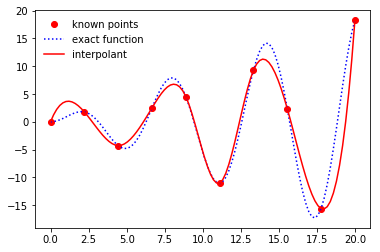

In [16]:
def f_exact(x):
    return np.sin(x)*x

N = 10
x = np.linspace(0, 20, N)

y = f_exact(x)

fInterp = interpolate.interp1d(x, y, kind=3)

# use finer points when we plot
xplot = np.linspace(0, 20, 10*N)

plt.plot(x, y, "ro", label="known points")
plt.plot(xplot, f_exact(xplot), "b:", label="exact function")
plt.plot(xplot, fInterp(xplot), "r-", label="interpolant")

plt.legend(frameon=False, loc="best")

### Multi-d interpolation

Here's an example of mult-d interpolation from the official tutorial.

First we define the "answer" -- this is the true function that we will sample at a number of points and then try to use interpolation to recover

In [17]:
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

here will use mgrid to create the grid of (x,y) where we know func exactly -- this will be for plotting.  Note the fun trick here, this is not really a function, but rather something that can magically look like an array, and we index it with the start:stop:stride.  If we set stride to an imaginary number, then it is interpreted as the number of points to put between the start and stop

In [18]:
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

In [19]:
print(grid_x.shape)
print(grid_y.shape)

(100, 200)
(100, 200)


here's what the exact function looks like -- note that our function is defined in x,y, but imshow is meant for plotting an array, so the first index is the row.  We take the transpose when plotting

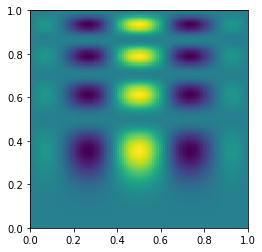

In [20]:
plt.imshow(func(grid_x, grid_y).T, extent=(0,1,0,1), origin="lower")

now we'll define 1000 random points where we'll sample the function

In [21]:
points = np.random.rand(1000, 2)
values = func(points[:,0], points[:,1])

Here's what those points look like:

(0, 1)

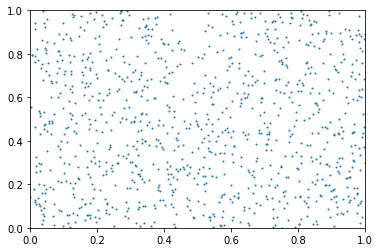

In [22]:
plt.scatter(points[:,0], points[:,1], s=1)
plt.xlim(0,1)
plt.ylim(0,1)

The interpolate.griddata() function provides many ways to interpolate a collection of points into a uniform grid.  There are many different interpolation methods within this function

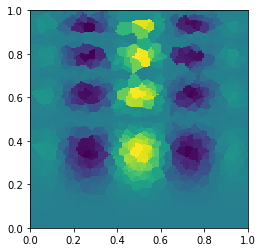

In [23]:
grid_z0 = interpolate.griddata(points, values, (grid_x, grid_y), method='nearest')
plt.imshow(grid_z0.T, extent=(0,1,0,1), origin="lower")

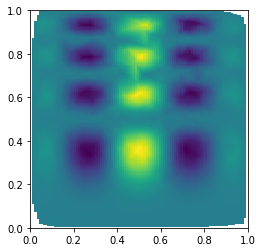

In [24]:
grid_z0 = interpolate.griddata(points, values, (grid_x, grid_y), method='linear')
plt.imshow(grid_z0.T, extent=(0,1,0,1), origin="lower")

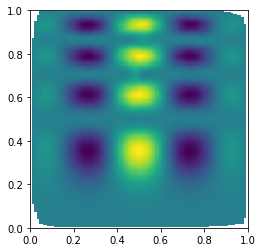

In [25]:
grid_z0 = interpolate.griddata(points, values, (grid_x, grid_y), method='cubic')
plt.imshow(grid_z0.T, extent=(0,1,0,1), origin="lower")

# Root Finding

Often we need to find a value of a variable that zeros a function -- this is _root finding_.  Sometimes, this is a multidimensional problem.

The `brentq()` routine offers a very robust method for find roots from a scalar function.  You do need to provide an interval that bounds the root.

$f(x) = \frac{x e^x}{e^x - 1} - 5$

In [26]:
import scipy.optimize as optimize

def f(x):
    # this is the non-linear equation that comes up in deriving Wien's law for radiation
    return (x*np.exp(x)/(np.exp(x) - 1.0) - 5.0)

root, r = optimize.brentq(f, 0.1, 10.0, full_output=True)

print(root)
print(r.converged)

4.965114231744287
True


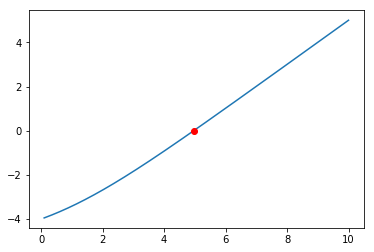

In [27]:
x = np.linspace(0.1, 10.0, 1000)
plt.plot(x, f(x))
plt.plot(np.array([root]), np.array([f(root)]), 'ro')

# ODEs

Many methods exist for integrating ordinary differential equations.  Most will want you to write your ODEs as a system of first order equations.

This system of ODEs is the Lorenz system:

$$\frac{dx}{dt} = \sigma (y - x)$$
$$\frac{dy}{dt} = rx - y - xz$$
$$\frac{dz}{dt} = xy - bz$$

the steady states of this system correspond to:

$${\bf f}({\bf x}) = 
\left (
\sigma (y -x), 
rx - y -xz, 
xy - bz
\right )^\intercal
= 0$$


In [28]:
# system parameters
sigma = 10.0
b = 8./3.
r = 28.0

def rhs(t, x):
    xdot = sigma*(x[1] - x[0])
    ydot = r*x[0] - x[1] - x[0]*x[2]
    zdot = x[0]*x[1] - b*x[2]

    return np.array([xdot, ydot, zdot])

def jac(t, x):

    return np.array(
        [ [-sigma, sigma, 0.0], 
          [r - x[2], -1.0, -x[0]],
          [x[1], x[0], -b] ])

def f(x):
    return rhs(0.,x), jac(0.,x)

SciPy >= 1.0.0 has a uniform interface to the different ODE solvers, `solve_ivp()` -- we use that here.  Note, some (but not all) solvers provide a way to get the solution data at intermediate times (called dense output).

In [29]:
def ode_integrate(X0, dt, tmax):
    """ integrate using the VODE method, storing the solution each dt """

    r = integrate.solve_ivp(rhs, (0.0, tmax), X0,
                            method="RK45", dense_output=True)

    # get the solution at intermediate times
    ts = np.arange(0.0, tmax, dt)
    
    Xs = r.sol(ts)
    return ts, Xs

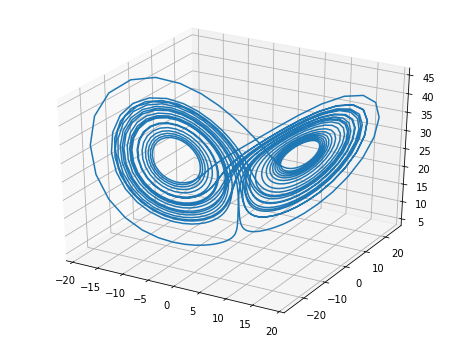

In [30]:
t, X = ode_integrate([1.0, 1.0, 20.0], 0.02, 30)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(X[0,:], X[1,:], X[2,:])
fig.set_size_inches(8.0,6.0)

### Multi-variate root find

we can find the steady points in this system by doing a multi-variate root find on the RHS vector

In [31]:
sol1 = optimize.root(f, [1., 1., 1.], jac=True)
print(sol1.x)

sol2 = optimize.root(f, [10., 10., 10.], jac=True)
print(sol2.x)

sol3 = optimize.root(f, [-10., -10., -10.], jac=True)
print(sol3.x)

[0. 0. 0.]
[ 8.48528137  8.48528137 27.        ]
[-8.48528137 -8.48528137 27.        ]


Text(0.5, 0, 'z')

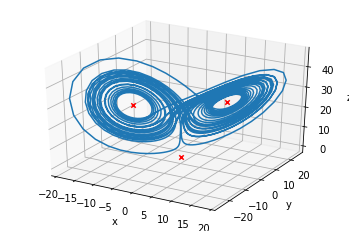

In [32]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(X[0,:], X[1,:], X[2,:])

ax.scatter(sol1.x[0], sol1.x[1], sol1.x[2], marker="x", color="r")
ax.scatter(sol2.x[0], sol2.x[1], sol2.x[2], marker="x", color="r")
ax.scatter(sol3.x[0], sol3.x[1], sol3.x[2], marker="x", color="r")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

### Stiff system of ODEs

A stiff system of ODEs is one where there are multiple disparate timescales for change and we need to respect all of them to get an accurate solution

Here is an example from Chemical Kinetics (see, ex. Byrne & Hindmarsh 1986, or the VODE source code)

\begin{equation}
\frac{d}{dt} \left (
   \begin{array}{c} y_1 \newline y_2 \newline y_3 \end{array}
  \right ) =
%
\left (
 \begin{array}{rrr}
  -0.04 y_1 & + 10^4 y_2 y_3  & \newline
   0.04 y_1 & - 10^4 y_2 y_3 & -3\times 10^7 y_2^2 \newline
   &  & 3\times 10^7 y_2^2 
\end{array}
\right )
\end{equation}

\begin{equation}
{\bf J} = \left (
\begin{array}{ccc}
  -0.04 & 10^4 y_3 & 10^4 y_2 \newline
   0.04 & -10^4 y_3 - 6\times 10^7 y_2 & -10^4 y_2 \newline
   0 & 6\times 10^7 y_2 & 0 
\end{array}
\right )
\end{equation}

start with $y_1(0) = 1, y_2(0) = y_3(0) = 0$.  Long term behavior is $y_1, y_2 \rightarrow 0; y_3 \rightarrow 1$

In [33]:
def rhs(t, Y):
    """ RHS of the system -- using 0-based indexing """
    y1 = Y[0]
    y2 = Y[1]
    y3 = Y[2]

    dy1dt = -0.04*y1 + 1.e4*y2*y3
    dy2dt =  0.04*y1 - 1.e4*y2*y3 - 3.e7*y2**2
    dy3dt =                         3.e7*y2**2

    return np.array([dy1dt, dy2dt, dy3dt])


def jac(t, Y):
    """ J_{i,j} = df_i/dy_j """

    y1 = Y[0]
    y2 = Y[1]
    y3 = Y[2]

    df1dy1 = -0.04
    df1dy2 = 1.e4*y3
    df1dy3 = 1.e4*y2

    df2dy1 = 0.04
    df2dy2 = -1.e4*y3 - 6.e7*y2
    df2dy3 = -1.e4*y2

    df3dy1 = 0.0
    df3dy2 = 6.e7*y2
    df3dy3 = 0.0

    return np.array([ [ df1dy1, df1dy2, df1dy3 ],
                      [ df2dy1, df2dy2, df2dy3 ],
                      [ df3dy1, df3dy2, df3dy3 ] ])

In [34]:
def vode_integrate(Y0, tmax):
    """ integrate using the NDF method """

    r = integrate.solve_ivp(rhs, (0.0, tmax), Y0,
                            method="BDF", jac=jac, rtol=1.e-7, atol=1.e-10)

    # Note: this solver does not have a dens_output method, instead we 
    # access the solution data where it was evaluated internally via
    # the return object
    
    return r.t, r.y

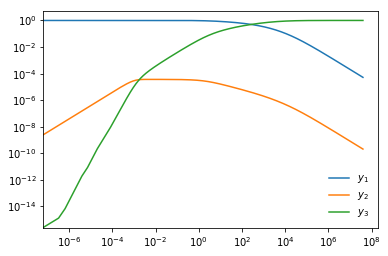

In [35]:
Y0 = np.array([1.0, 0.0, 0.0])
tmax = 4.e7

ts, Ys = vode_integrate(Y0, tmax)

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt.plot(ts, Ys[0,:], label=r"$y_1$")
plt.plot(ts, Ys[1,:], label=r"$y_2$")
plt.plot(ts, Ys[2,:], label=r"$y_3$")

plt.legend(loc="best", frameon=False)

# Fitting

Fitting is used to match a model to experimental data.  E.g. we have N points of $(x_i, y_i)$ with associated errors, $\sigma_i$, and we want to find a simply function that best represents the data.

Usually this means that we will need to define a metric, often called the residual, for how well our function matches the data, and then minimize this residual.  Least-squares fitting is a popular formulation.

We want to fit our data to a function $Y(x, \{a_j\})$, where $a_j$ are model parameters we can adjust.  We want to find the optimal $a_j$ to minimize the distance of $Y$ from our data:
$$\Delta_i = Y(x_i, \{a_j\}) - y_i$$

Least-squares minimizes $\chi^2$:
$$\chi^2(\{a_j\}) = \sum_{i=1}^N \left ( \frac{\Delta_i}{\sigma_i} \right )^2$$

### general linear least squares

First we'll make some experimental data (a quadratic with random fashion).  We use the randn() function to provide Gaussian normalized errors.

<ErrorbarContainer object of 3 artists>

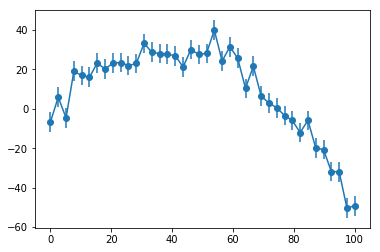

In [36]:
def y_experiment2(a1, a2, a3, sigma, x):
    """ return the experimental data in a quadratic + random fashion,                              
        with a1, a2, a3 the coefficients of the quadratic and sigma is                             
        the error.  This will be poorly matched to a linear fit for                                
        a3 != 0 """

    N = len(x)

    # randn gives samples from the "standard normal" distribution                                  
    r = np.random.randn(N)

    y = a1 + a2*x + a3*x*x + sigma*r

    return y

N = 40
sigma = 5.0*np.ones(N)

x = np.linspace(0, 100.0, N)
y = y_experiment2(2.0, 1.50, -0.02, sigma, x)

plt.scatter(x,y)
plt.errorbar(x, y, yerr=sigma)#, fmt=None)

[-2.72724423  1.7037052  -0.02171814]


AttributeError: 'NoneType' object has no attribute 'lower'

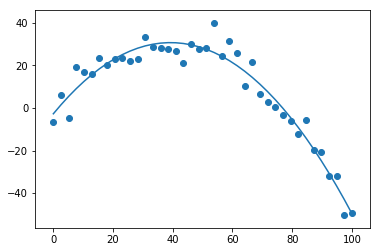

In [37]:
def resid(avec, x, y, sigma):
    """ the residual function -- this is what will be minimized by the
        scipy.optimize.leastsq() routine.  avec is the parameters we
        are optimizing -- they are packed in here, so we unpack to
        begin.  (x, y) are the data points 

        scipy.optimize.leastsq() minimizes:

           x = arg min(sum(func(y)**2,axis=0))
                    y

        so this should just be the distance from a point to the curve,
        and it will square it and sum over the points
        """

    a0, a1, a2 = avec
    
    return (y - (a0 + a1*x + a2*x**2))/sigma


# initial guesses
a0, a1, a2 = 1, 1, 1

afit, flag = optimize.leastsq(resid, [a0, a1, a2], args=(x, y, sigma))

print(afit)

plt.plot(x, afit[0] + afit[1]*x + afit[2]*x*x )
plt.scatter(x,y)
plt.errorbar(x, y, yerr=sigma, fmt=None)

$\chi^2$

In [ ]:
chisq = sum(np.power(resid(afit, x, y, sigma),2))
normalization = len(x)-len(afit)
print(chisq/normalization)

### a nonlinear example

our experiemental data -- an exponential

In [ ]:
a0 = 2.5
a1 = 2./3.
sigma = 5.0

a0_orig, a1_orig = a0, a1

x = np.linspace(0.0, 4.0, 25)
y = a0*np.exp(a1*x) + sigma*np.random.randn(len(x))

plt.scatter(x,y)
plt.errorbar(x, y, yerr=sigma)#, fmt=None, label="_nolegend_")

our function to minimize

In [39]:
def resid(avec, x, y):
    """ the residual function -- this is what will be minimized by the                             
        scipy.optimize.leastsq() routine.  avec is the parameters we                               
        are optimizing -- they are packed in here, so we unpack to                                 
        begin.  (x, y) are the data points                                                         
                                                                                                   
        scipy.optimize.leastsq() minimizes:                                                        
                                                                                                   
           x = arg min(sum(func(y)**2,axis=0))                                                     
                    y                                                                              
                                                                                                   
        so this should just be the distance from a point to the curve,                             
        and it will square it and sum over the points                                              
        """

    a0, a1 = avec

    # note: if we wanted to deal with error bars, we would weight each                             
    # residual accordingly                                                                         
    return y - a0*np.exp(a1*x)

In [40]:
a0, a1 = 1, 1
afit, flag = optimize.leastsq(resid, [a0, a1], args=(x, y))

print(flag)
print(afit)

2
[-2.66328431e-14  1.00000000e+00]


NameError: name 'a0_orig' is not defined

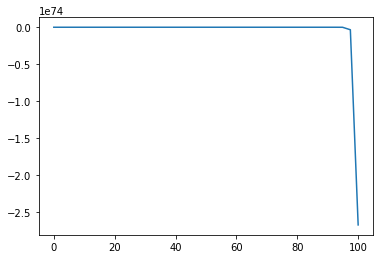

In [38]:
plt.plot(x, afit[0]*np.exp(afit[1]*x),
           label=r"$a_0 = $ %f; $a_1 = $ %f" % (afit[0], afit[1]))
plt.plot(x, a0_orig*np.exp(a1_orig*x), ":", label="original function")
plt.legend(numpoints=1, frameon=False)
plt.scatter(x,y, c="k")
plt.errorbar(x, y, yerr=sigma)#, fmt=None, label="_nolegend_")

# FFTs

Fourier transforms convert a physical-space (or time series) representation of a function into frequency space.  This provides an equivalent representation of the data with a new view.

The FFT and its inverse in NumPy use:
$$F_k = \sum_{n=0}^{N-1} f_n e^{-2\pi i nk/N}$$

$$f_n = \frac{1}{N} \sum_{k=0}^{N-1} F_k 
   e^{2\pi i n k/N}$$
   

Both NumPy and SciPy have FFT routines that are similar.  However, the NumPy version returns the data in a more convenient form.

It's always best to start with something you understand -- let's do a simple sine wave.  Since our function is real, we can use the rfft routines in NumPy -- the understand that we are working with real data and they don't return the negative frequency components.

One important caveat -- FFTs assume that you are periodic.  If you include both endpoints of the domain in the points that comprise your sample then you will not match this assumption.  Here we use endpoint=False with linspace()

In [ ]:
def single_freq_sine(npts):

    # a pure sine with no phase shift will result in pure imaginary                                         
    # signal                                                                                                
    f_0 = 0.2

    xmax = 10.0/f_0
    
    xx = np.linspace(0.0, xmax, npts, endpoint=False)

    f = np.sin(2.0*np.pi*f_0*xx)

    return xx, f

To make our life easier, we'll define a function that plots all the stages of the FFT process

In [ ]:
def plot_FFT(xx, f):

    npts = len(xx)

    # Forward transform: f(x) -> F(k)                                                                       
    fk = np.fft.rfft(f)

    # Normalization -- the '2' here comes from the fact that we are                                         
    # neglecting the negative portion of the frequency space, since                                         
    # the FFT of a real function contains redundant information, so                                         
    # we are only dealing with 1/2 of the frequency space.                                                  
    #                                                                                                       
    # technically, we should only scale the 0 bin by N, since k=0 is                                        
    # not duplicated -- we won't worry about that for these plots                                           
    norm = 2.0/npts

    fk = fk*norm

    fk_r = fk.real
    fk_i = fk.imag

    # the fftfreq returns the postive and negative (and 0) frequencies                                      
    # the newer versions of numpy (>=1.8) have an rfftfreq() function                                       
    # that really does what we want -- we'll use that here.                                                 
    k = np.fft.rfftfreq(npts)

    # to make these dimensional, we need to divide by dx.  Note that                                        
    # max(xx) is not the true length, since we didn't have a point                                          
    # at the endpoint of the domain.                                                                        
    kfreq = k*npts/(max(xx) + xx[1])

    # Inverse transform: F(k) -> f(x) -- without the normalization                                          
    fkinv = np.fft.irfft(fk/norm)

    # plots
    plt.subplot(411)

    plt.plot(xx, f)
    plt.xlabel("x")
    plt.ylabel("f(x)")

    plt.subplot(412)

    plt.plot(kfreq, fk_r, label=r"Re($\mathcal{F}$)")
    plt.plot(kfreq, fk_i, ls=":", label=r"Im($\mathcal{F}$)")
    plt.xlabel(r"$\nu_k$")
    plt.ylabel("F(k)")

    plt.legend(fontsize="small", frameon=False)

    plt.subplot(413)

    plt.plot(kfreq, np.abs(fk))
    plt.xlabel(r"$\nu_k$")
    plt.ylabel(r"|F(k)|")

    plt.subplot(414)

    plt.plot(xx, fkinv.real)
    plt.xlabel(r"$\nu_k$")
    plt.ylabel(r"inverse F(k)")

    f = plt.gcf()
    
    f.set_size_inches(10,8)
    plt.tight_layout()


In [ ]:
npts = 128
xx, f = single_freq_sine(npts)
plot_FFT(xx, f)

A cosine is shifted in phase by pi/2

In [ ]:
def single_freq_cosine(npts):

    # a pure cosine with no phase shift will result in pure real                                            
    # signal                                                                                                
    f_0 = 0.2

    xmax = 10.0/f_0

    xx = np.linspace(0.0, xmax, npts, endpoint=False)

    f = np.cos(2.0*np.pi*f_0*xx)

    return xx, f

In [ ]:
xx, f = single_freq_cosine(npts)
plot_FFT(xx, f)

Now let's look at a sine with a pi/4 phase shift

In [ ]:
def single_freq_sine_plus_shift(npts):

    # a pure sine with no phase shift will result in pure imaginary                                         
    # signal                                                                                                
    f_0 = 0.2

    xmax = 10.0/f_0

    xx = np.linspace(0.0, xmax, npts, endpoint=False)

    f = np.sin(2.0*np.pi*f_0*xx + np.pi/4)

    return xx, f

In [ ]:
xx, f = single_freq_sine_plus_shift(npts)
plot_FFT(xx, f)

### A frequency filter

we'll setup a simple two-frequency sine wave and filter a component

In [ ]:
def two_freq_sine(npts):

    # a pure sine with no phase shift will result in pure imaginary             
    # signal                                                                    
    f_0 = 0.2
    f_1 = 0.5

    xmax = 10.0/f_0

    # we call with endpoint=False -- if we include the endpoint, then for       
    # a periodic function, the first and last point are identical -- this       
    # shows up as a signal in the FFT.                                          
    xx = np.linspace(0.0, xmax, npts, endpoint=False)

    f = 0.5*(np.sin(2.0*np.pi*f_0*xx) + np.sin(2.0*np.pi*f_1*xx))

    return xx, f

In [ ]:
npts = 256

xx, f = two_freq_sine(npts)

plt.plot(xx, f)

we'll take the transform: f(x) -> F(k)

In [ ]:
# normalization factor: the 2 here comes from the fact that we neglect          
# the negative portion of frequency space because our input function            
# is real                                                                       
norm = 2.0/npts
fk = norm*np.fft.rfft(f)

ofk_r = fk.real.copy()
ofk_i = fk.imag.copy()

# get the frequencies
k = np.fft.rfftfreq(len(xx))

# since we don't include the endpoint in xx, to normalize things, we need       
# max(xx) + dx to get the true length of the domain
#
# This makes the frequencies essentially multiples of 1/dx
kfreq = k*npts/(max(xx) + xx[1])


plt.plot(kfreq, fk.real, label="real")
plt.plot(kfreq, fk.imag, ":", label="imaginary")
plt.legend(frameon=False)

Filter out the higher frequencies

In [ ]:
fk[kfreq > 0.4] = 0.0

# element 0 of fk is the DC component                                           
fk_r = fk.real
fk_i = fk.imag


# Inverse transform: F(k) -> f(x)                                               
fkinv = np.fft.irfft(fk/norm)

plt.plot(xx, fkinv.real)

# Linear Algebra

### general manipulations of matrices

you can use regular NumPy arrays or you can use a special matrix class that offers some short cuts

In [ ]:
a = np.array([[1.0, 2.0], [3.0, 4.0]])

In [ ]:
print(a)
print(a.transpose())
print(a.T)

In [ ]:
ainv = np.linalg.inv(a)
print(ainv)

In [ ]:
print(np.dot(a, ainv))

the eye() function will generate an identity matrix (as will the identity())

In [ ]:
print(np.eye(2))
print(np.identity(2))

we can solve Ax = b

In [ ]:
b = np.array([5, 7])
x = np.linalg.solve(a, b)
print(x)

### The matrix class

In [ ]:
A = np.matrix('1.0 2.0; 3.0 4.0')
print(A)
print(A.T)

In [ ]:
X = np.matrix('5.0 7.0')
Y = X.T

print(A*Y)

In [ ]:
print(A.I*Y)

### tridiagonal matrix solve

Here we'll solve the equation:

$$f^{\prime\prime} = g(x)$$

with $g(x) = sin(x)$, and the domain $x \in [0, 2\pi]$, with boundary conditions $f(0) = f(2\pi) = 0$.  The solution is simply $f(x) = -sin(x)$.

We'll use a grid of $N$ points with $x_0$ on the left boundary and $x_{N-1}$ on the right boundary.

We difference our equation as:

$$f_{i+1} - 2 f_i + f_{i-1} = \Delta x^2 g_i$$

We keep the boundary points fixed, so we only need to solve for the $N-2$ interior points.  Near the boundaries, our difference is:
$$f_2 - 2 f_1 = \Delta x^2 g_1$$

and

$$-2f_{N-1} + f_{N-2} = \Delta x^2 g_{N-1}$$.

We can write the system of equations for solving for the $N-2$ interior points as:

\begin{equation}
A = \left (
\begin{array}{ccccccc}
-2 &  1 &    &        &         &           &          \newline
1  & -2 &  1 &        &         &           &          \newline
   &  1 & -2 & 1      &         &           &          \newline
   &         & \ddots & \ddots & \ddots  &           &          \newline
   &         &        & \ddots & \ddots  & \ddots  &          \newline
   &         &        &        & 1       & -2 & 1  \newline
   &         &        &        &         & 1  & -2 \newline
\end{array}
\right )
\end{equation}

\begin{equation}
x = \left (
\begin{array}{c}
f_\mathrm{1} \\\
f_\mathrm{2} \\\
f_\mathrm{3} \\\
\vdots \\\
\vdots \\\
f_\mathrm{N-2} \\\
f_\mathrm{N-1} \\\
\end{array}
\right )
\end{equation}

\begin{equation}
b = \Delta x^2 \left (
\begin{array}{c}
g_\mathrm{1} \\\
g_\mathrm{2} \\\
g_\mathrm{3} \\\
\vdots \\\
\vdots \\\
g_\mathrm{N-2} \\\
g_\mathrm{N-1}\\\
\end{array}
\right )
\end{equation}

Then we just solve $A x = b$

In [ ]:
import scipy.linalg as linalg

# our grid -- including endpoints
N = 100
x = np.linspace(0.0, 2.0*np.pi, N, endpoint=True)
dx = x[1]-x[0]

# our source
g = np.sin(x)

# our matrix will be tridiagonal, with [1, -2, 1] on the diagonals
# we only solve for the N-2 interior points

# diagonal
d = -2*np.ones(N-2)

# upper -- note that the upper diagonal has 1 less element than the
# main diagonal.  The SciPy banded solver wants the matrix in the 
# form:
#
# *    a01  a12  a23  a34  a45    <- upper diagonal
# a00  a11  a22  a33  a44  a55    <- diagonal
# a10  a21  a32  a43  a54   *     <- lower diagonal
#

u = np.ones(N-2)
u[0] = 0.0

# lower
l = np.ones(N-2)
l[N-3] = 0.0

# put the upper, diagonal, and lower parts together as a banded matrix
A = np.matrix([u,d,l])

# solve A sol = dx**2 g for the inner N-2 points
sol = linalg.solve_banded((1,1), A, dx**2*g[1:N-1])

plt.plot(x[1:N-1], sol)

In [ ]:
v = np.random.randint(0, 100, 1000)
%timeit v + 1

In [ ]:
lst = list(v)
%timeit [ val + 2 for val in lst]